# Preparation

## Import Libraries

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns

## Set Arguments & hyperparameters

In [2]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 1000
BATCH_SIZE = 34
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 50
INPUT_SHAPE = 128

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# check device
DEVICE

device(type='cuda')

# Define Dataloader

## Train & Validation Set loader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:578]
        elif self.mode == 'val':
            self.db = self.db[578:]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']


# Define Model(VGG-19)

In [38]:
from torchvision.models import vgg19


class VGG19(nn.Module):
    def __init__(self, NUM_CLS):
        super(VGG19, self).__init__()
        self.vgg = vgg19(pretrained=False)
        self.features_conv = self.vgg.features
        self.linear = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, NUM_CLS),
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.features_conv(x)
        x = torch.flatten(x,1)
        x = self.linear(x)
        x = self.softmax(x)
        return x

## Utils
### EarlyStopper

In [39]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [40]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [41]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [42]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 578 Val set samples: 68


#### Load model and other utils

In [43]:
# Load Model
model = VGG19(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [44]:
model

VGG19(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv

### epoch 단위 학습 진행

In [45]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0%|                                                                                         | 0/1000 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 6.00 GiB total capacity; 4.08 GiB already allocated; 0 bytes free; 4.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Inference
### 모델 로드

In [16]:
TRAINED_MODEL_PATH = 'best.pt'

## confusion matrix

In [17]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [18]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

model.eval()
with torch.no_grad():
    for batch_index, (img, label) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

with torch.no_grad():
    for batch_index, (img, label) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label.numpy()))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())

17it [00:06,  2.47it/s]
2it [00:00,  2.48it/s]



정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
AUC: 1.0000
F1: 1.0000


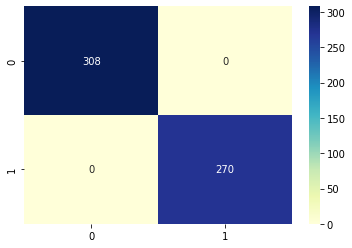

In [19]:
get_clf_eval(train_actual, train_pred_lst)


정확도: 0.7794
정밀도: 0.8800
재현율: 0.6471
AUC: 0.7794
F1: 0.7755


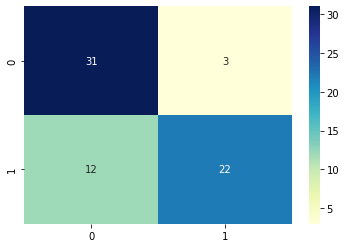

In [20]:
get_clf_eval(validation_actual, validation_pred_lst)

### Load dataset

In [21]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [22]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


### 추론 진행

In [23]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:00,  1.01it/s]

tensor([[9.9998e-01, 2.0674e-05],
        [9.9914e-01, 8.6014e-04],
        [9.9438e-01, 5.6196e-03],
        [9.2767e-02, 9.0723e-01],
        [9.8741e-01, 1.2592e-02],
        [3.1749e-06, 1.0000e+00],
        [1.6044e-03, 9.9840e-01],
        [7.8440e-02, 9.2156e-01],
        [1.3884e-01, 8.6116e-01],
        [4.2473e-07, 1.0000e+00],
        [9.9963e-01, 3.7104e-04],
        [9.9928e-01, 7.1690e-04],
        [9.9998e-01, 2.2702e-05],
        [9.9998e-01, 1.6049e-05],
        [9.9974e-01, 2.5918e-04],
        [1.0000e+00, 4.9491e-07],
        [8.3480e-01, 1.6520e-01],
        [1.0000e+00, 1.7216e-07],
        [9.7831e-01, 2.1690e-02],
        [9.9873e-01, 1.2740e-03],
        [1.0000e+00, 1.7932e-09],
        [9.9994e-01, 5.6686e-05],
        [9.8775e-01, 1.2249e-02],
        [9.9995e-01, 5.3763e-05],
        [1.0452e-02, 9.8955e-01],
        [9.9999e-01, 9.7956e-06],
        [9.9991e-01, 9.4280e-05],
        [8.0732e-01, 1.9268e-01],
        [6.0370e-08, 1.0000e+00],
        [1.476

2it [00:01,  1.24it/s]

tensor([[9.9963e-01, 3.6882e-04],
        [6.5627e-02, 9.3437e-01],
        [2.1291e-02, 9.7871e-01],
        [6.0814e-01, 3.9186e-01],
        [3.9961e-07, 1.0000e+00],
        [9.9955e-01, 4.5361e-04],
        [3.8972e-05, 9.9996e-01],
        [2.5869e-03, 9.9741e-01],
        [1.0000e+00, 1.7002e-06],
        [4.5400e-08, 1.0000e+00],
        [6.8614e-02, 9.3139e-01],
        [6.7181e-03, 9.9328e-01],
        [8.7165e-02, 9.1283e-01],
        [1.0000e+00, 4.5522e-07],
        [9.8610e-01, 1.3903e-02],
        [9.9994e-01, 5.8375e-05],
        [6.1594e-06, 9.9999e-01],
        [3.6133e-06, 1.0000e+00],
        [6.0641e-01, 3.9359e-01],
        [9.9894e-01, 1.0645e-03],
        [7.5678e-06, 9.9999e-01],
        [7.8444e-01, 2.1556e-01],
        [4.5900e-01, 5.4100e-01],
        [9.0825e-05, 9.9991e-01],
        [9.9986e-01, 1.4094e-04],
        [9.9990e-01, 1.0146e-04],
        [2.2185e-06, 1.0000e+00],
        [9.9999e-01, 5.6797e-06],
        [1.0000e+00, 1.7735e-07],
        [1.000

3it [00:02,  1.31it/s]

tensor([[2.7424e-03, 9.9726e-01],
        [9.9998e-01, 1.6729e-05],
        [9.9999e-01, 1.3921e-05],
        [9.9700e-01, 3.0021e-03],
        [1.0000e+00, 4.8190e-07],
        [9.9999e-01, 1.0527e-05],
        [3.2867e-03, 9.9671e-01],
        [1.0000e+00, 4.7472e-06],
        [1.0000e+00, 1.4647e-08],
        [9.9993e-01, 7.4853e-05],
        [3.4805e-03, 9.9652e-01],
        [1.1164e-05, 9.9999e-01],
        [1.4302e-03, 9.9857e-01],
        [2.9466e-03, 9.9705e-01],
        [9.9999e-01, 1.1304e-05],
        [5.3147e-05, 9.9995e-01],
        [1.8100e-02, 9.8190e-01],
        [7.5305e-02, 9.2470e-01],
        [9.9997e-01, 2.9893e-05],
        [5.4421e-03, 9.9456e-01],
        [9.9249e-01, 7.5141e-03],
        [6.9805e-01, 3.0195e-01],
        [9.9651e-01, 3.4914e-03],
        [9.9963e-01, 3.7260e-04],
        [2.8639e-04, 9.9971e-01],
        [3.7308e-05, 9.9996e-01],
        [1.0000e+00, 3.5911e-08],
        [9.8364e-01, 1.6355e-02],
        [1.8799e-06, 1.0000e+00],
        [2.427

### 결과 저장

In [24]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction(VGG19).csv', index=False)